# Exploring and Simulating Polymer Folding Through Monte Carlo Simulations

### Introduction

Polymer physics has become an increasingly important subject within various scientific disciplines in the recent years, most notably in the description of biopolymers like DNA. DNA-strands go through multiple essential and incricate processes of folding, for example when an entire DNA-strand must confine itself within the nuclues of a cell. Errors in these foldings have been linked to numerous hereditary diseases, such as Alzheimer's and Huntington's disease. This project aims to explore and replicate the folding of polymers using Monte Carlo-methods taking physical principles into account.

<hr>

In [65]:
# Import and define necessary libraries and constants
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
import warnings

# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore", message="overflow encountered in exp")
warnings.filterwarnings("ignore", message="overflow encountered in multiply")


#Boltzmanns konstant
k_B = 1.38e-23 #J/K

**(1a)** To begin the process of polymer-simulation, it is necessary to implement a polymer and corresponding functions needed for rotations and visualization. There are several ways to implement the polymer. One way is to use an $N \times N$ matrix containing the index of each individual monomer. Another possibility is to store the polymer as an array of length $N$ where each element of the array contains an array of length $2$, again containing the $x$ and $y$ coordinates of the monomer with the respective index. This approach will be used throughout the project. Note that these polymers are zero-indexed, as the numpy arrays used in the implementation are zero-indexed.

The advantages of going for this approach are that operations done on the entirety of the data structure achieve an asymptotic runtime of $O(N)$, an order of magnitude better than $O(N^2)$ for the $N \times N$ matrix approach. Note that element-wise operations are assumed to be $O(1)$. This is achieved while the structure is still compatible with numpy, facilitating the advantages of its fast implementations and parallell computing possibilities.

**(1b)** The function `createPolymer` implemented below initializes a polymer spanning a horizontal line. 

In [56]:
def createPolymer(N):
    """Inputs a number N and returns a horizontal polymer of length N."""
    
    polymer = np.zeros((N,2))
    polymer[:,0] = np.linspace(0,N-1,N)
    polymer[:,1] = N//2
    return polymer

**(1c)** Looking at the rotation and subsequent potential change of energy in polymers, it is important to note the result of a rotation about the first and last monomer. This rotation will not alter the energy at all. Changes in energy in polymers due to rotation arise when monomers that were not previously interacting are placed such that an interaction arises, or vice versa. As a rotation around a monomer at the endpoint rotates the entire polymer, no relative distances are altered. Therefore, when simulating random rotations, such rotations can be disregarded without consequences for the final result. 

**(1d)** When analyzing polymers, it is useful to visualize the polymer to help understand both how the polymer folds and how its energy changes. The function `visualizePolymer` doing just this is implemented below, as well as the function `visualizeMultiplePolymers` to visualize multiple polymers side by side for comparison.

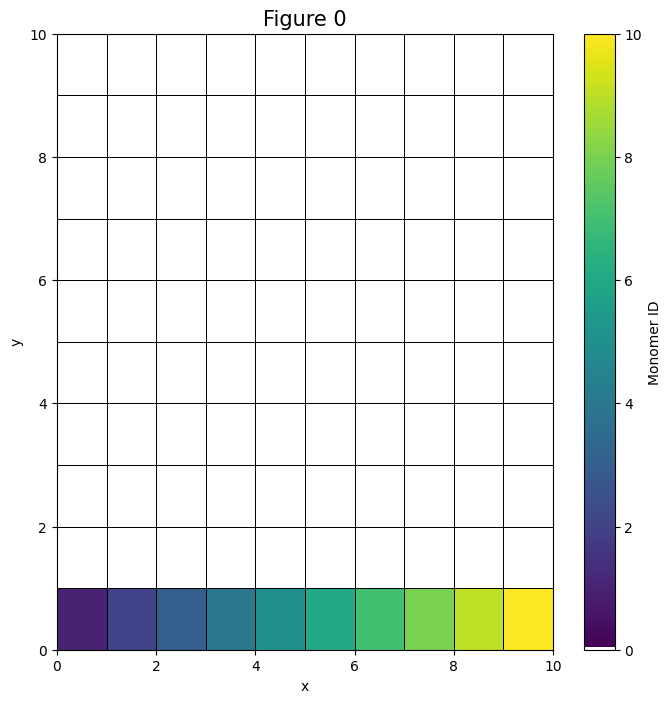

In [61]:
def visualizePolymer(polymer, title=""):
    """Inputs a polymer and an optional title, and visualizes the polymer on a grid."""
    
    # Calculate the minimum and maximum coordinates of the polymer
    minX = int(np.min(polymer[:, 0]))
    maxX = int(np.max(polymer[:, 0]))
    minY = int(np.min(polymer[:, 1]))
    maxY = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    gridWidth = maxX - minX + 1
    gridHeight = maxY - minY + 1
    gridSize = int(np.max([gridHeight, gridWidth]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((gridSize, gridSize))

    # Plot the polymer on the grid
    for i, (x, y) in enumerate(polymer):
        grid[int(y - minY), int(x - minX)] = i + 1

    # Visualize the grid
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x')
    plt.ylabel('y')
    if title != "":
        plt.title(title, fontsize=15)
    plt.show()
    

def visualizeMultiplePolymers(polymer, ax):
    """Inputs a polymer and a matplotlib axis, and places the polymer on the axis."""

    # Calculate the minimum and maximum coordinates of the polymer
    minX = int(np.min(polymer[:, 0]))
    maxX = int(np.max(polymer[:, 0]))
    minY = int(np.min(polymer[:, 1]))
    maxY = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    gridWidth = maxX - minX + 1
    gridHeight = maxY - minY + 1
    gridSize = int(np.max([gridHeight, gridWidth]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((gridSize, gridSize))

    for i, (x, y) in enumerate(polymer):
        grid[int(y - minY), int(x - minX)] = i + 1

    # Create pseudocolor plot
    mesh = ax.pcolormesh(grid, edgecolors='black', linewidth=0.5, cmap=cmap)
    
    # Add colorbar with custom indexing
    cbar = plt.colorbar(mesh, ax=ax, ticks=[])
    
    # Set label for colorbar
    cbar.set_label('Monomer ID')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

visualizePolymer(createPolymer(10), "Figure 0")

Figure 0: A horizontal polymer of length $10$

**(1e)** When simulating polymers' folding, it is possible for the simulation to return an illegal fold, for example by it folding in on itself. It is therefore necessary to ensure that a rotation returns a valid polymer. The function `isIntact` implemented below returns `True` if the polymer fullfills the following criteria:

1. The polymer has $N$ monomers that all have unique coordinates.
2. Monomer $i$ s a distance of $1$ from both monomer $i-1$ and $1+i$, where $i \in \left[1,N\right)$

The function returns `False` elsewise.

In [4]:
def isIntact(polymer, N):
    """Checks if a polymer is intact."""
    
    # Remove potential monomers in identical positions, and check if this shortens the polymer. If so, return false.
    uniLength = len(np.unique(polymer, axis=0))

    if uniLength != N:
        return False

    # Check if the distance between each adjacent monomer is 1, i.e. that the polymer chain is continous. If not, return false.
    for i in range(N-1): 
        xDist = np.abs(polymer[i+1][0]-polymer[i][0])
        yDist = np.abs(polymer[i+1][1]-polymer[i][1])
        distance = xDist + yDist
        if distance != 1:
            return False
    return True

These two checks are sufficient to check the formal criteria given for an intact polymer when the polymer is defined using the applied data structure. The length of a polymer will always be $N$, as long as the algorithms operating on the polymer do not alter the length. Nevertheless, the first criteria will still ensure that this is the case. The parameter $N$ is the initial length of the polymer, and if the polymer consists of less than $N$ monomers, it must also always consist of less than $N$ unique monomers. 

The unique representation of a monomer is given by the list index of the coordinate representing the monomer.

For the final check, the symmetry in distance is utilized, namely that the distance between $a$ and $b$ is the distance between $b$ and $a$. Therefore, when using the algorithm above checking if each monomer except the leftmost has a distance of $1$ to its left neighbor, it implicitly checks that each monomer except the rightmost has a distance of $1$ to its right neighbor.

**(1f)** One way to rotate the polymer is to use the direction where the next monomer can be found from the previous one, and change this clockwisely or counterclockwisely depending on the rotation-direction. The function `createDirectionList` implemented below is useful when rotating in this way.

In [5]:
def createDirectionList(polymer):
    """Input the part of a polymer that you want to rotate, and find what direction it rotates."""
    
    # Create a zero-array that is the length of the polymer part that you want to rotate (minus 1)
    dir = np.zeros(len(polymer)-1)
    
    for i in range(len(polymer)-1):
        d = polymer[i+1] - polymer[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


The algorithm for rotation, `rotatePolymerOld` is implemented below. The asymptotic runtime of this algorithm is $O(N)$, but each step is inefficient. The function is called `rotatePolymerOld` as a new and improved version will be implemented in [1h](#task1h).

In [6]:
def rotatePolymerOld(polymer, rotationOrigin, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    
    rotatingBase = -1 
    polymer = np.copy(polymer)
    N = len(polymer)

    # Find index of monomer to rotate around
    for i in range(N):
        if np.array_equal(polymer[i], rotationOrigin):
            rotatingBase = i
            break
    
    # Find which side to rotate about. 
    rotateLeftPart = rotatingBase <= N//2

    directionList = createDirectionList(polymer)

    # Change the rotational direction in direction list according to rotating direction and which part to rotate.
    if rotateLeftPart:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4

    # Place the end of the polymer iteratively
    if rotateLeftPart:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, N):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

<a id='task1g' style='display:block; padding-top: 100px; margin-top: -100px;'></a>
**(1g)** To test `rotatePolymerOld`, `testRotate` is implemented. It will attempt a given number of rotations and return the number of valid rotations, where a valid rotation is one that fulfills the criteria given for `isIntact`. `rotatingFunction` is given as a parameter to allow performance comparisons between different implementations of polymer rotation. The default is set to `rotatePolymer` for later convenience, as this will be the name of the most efficient rotation algorithm which is yet to be implemented. In order to run the cell below without errors, the cell containing `testRotate` must be run first.

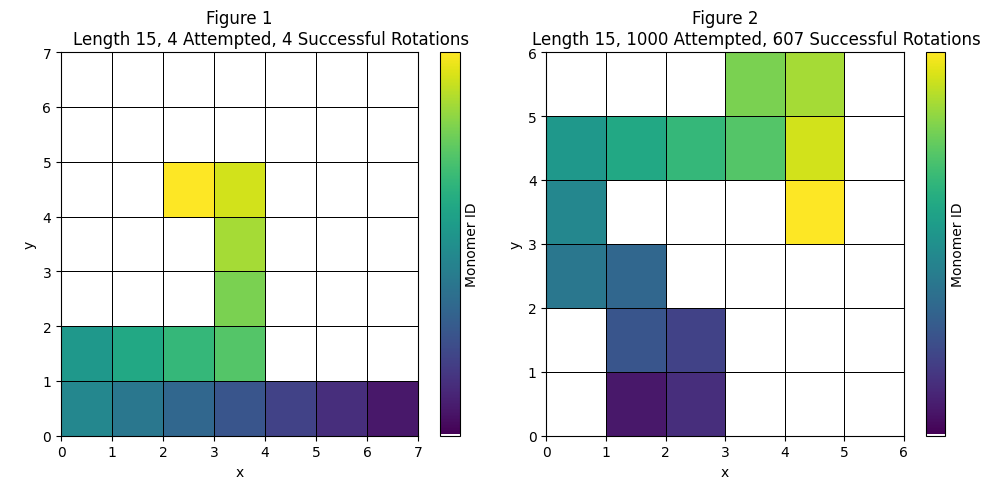

In [9]:
def testRotate(N, N_s, rotatingFunction=rotatePolymer):
    """Inputs the length of a polymer, a number of attempted rotations and a rotating function,
      and outputs the last position and number of successful rotations."""
    
    # Create a polymer with given length, aswell as an empty array and a counter for number of successfull rotations
    polymer = createPolymer(N)
    twistedPolymer = np.array([])
    successRotations = 0

    # Twist the given polymer N_s times
    for i in range(N_s):

        # Find a random monomer to rotate about, and a random direction, either clockwise or counterclockwise
        rotateMonomer = np.random.randint(1, N+1)
        rotateMonomer = polymer[rotateMonomer - 1]
        clockwise = np.random.randint(0,2) == 1

        # Create a new twisted polymer, depending on the random monomer and direction given above
        twistedPolymer = rotatingFunction(polymer, rotateMonomer, clockwise)

        # Check if the twisted polymer is intact, and if so, this is the new polymer, add 1 to the counter, and use this polymer for the remaining iterations
        # If not, the next iteration will use the last valid polymer
        if isIntact(twistedPolymer, N) == True:
            successRotations += 1 
            polymer = np.copy(twistedPolymer)
    
    return polymer, successRotations

# Create two test-rotations for a polymer that is N = 15 monomers long, one with N_s = 4 and the other with N_s = 1000
polymer4, successes4 = testRotate(15, 4, rotatePolymerOld)
polymer1000, successes1000 = testRotate(15, 1000, rotatePolymerOld)

polymerArray = np.array([polymer4, polymer1000])

# Visualize the end position of the two tests
fig, axs = plt.subplots(1, len(polymerArray), figsize=(10, 5))

# Plot each run on a separate subplot
for i, polymer in enumerate(polymerArray):
    visualizeMultiplePolymers(polymer, axs[i])

axs[0].set_title(f"""Figure 1
            Length 15, 4 Attempted, {successes4} Successful Rotations""")
axs[1].set_title(f"""Figure 2
            Length 15, 1000 Attempted, {successes1000} Successful Rotations""")
plt.tight_layout()
plt.show()


Figure 1,2: Visualizing two polymers with different numbers of attempted rotations.

As can be seen from the figures above, the polymer that goes through the most rotations is the one that has the most potential to curl up. The only criteria for performing a rotation at this stage is to return an intact polymer. Due to this, the rotating pattern is quite random and tends to vary greatly from execution to execution. As will be seen later, the resulting polymer becomes more predictable when regarding physical principles. 

<a id='task1h' style='display:block; padding-top: 100px; margin-top: -100px;'></a>
**(1h)** A more efficient way to implement rotation is to utilize rotational matrices. To rotate a point $\mathbf{p}$ with an angle $\theta$ around the origin, the linear transformation given by the matrix
$A = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}$
can be applied to $\mathbf{p}$. Because the only desired rotation is clockwisely and counterclockwisely, i.e.  to rotate 90 degrees, the matrices $A_+ = \begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}$
and  $A_- = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}$
 are the only ones necessary to consider. The entire coordinate system is then translated to have the origin where the monomer that the polymer rotates about is located, perform the rotation on the shortest part, and translate back. 


In [10]:
def rotatePolymer(polymer, rotationOrigin, clockwise = True):
    """Inputs a polymer and rotates the short end in the direction specified around rotation origin."""

    # Create a clockwise- or counterclockwise-rotation matrix, depending on the input.
    rotationMatrix =  np.array([[0, 1], [-1, 0]]) if clockwise else np.array([[0, -1], [1, 0]])

    # Find the index of the monomer you want the polymer to rotate about
    rotationCenterIdx = np.where((polymer == rotationOrigin).all(axis=1))[0][0]

    # Move the rotation center to the origin before rotating
    translatedPolymer = polymer - rotationOrigin

    # Make a copy of translatedPolymer to ensure no loss of data due to pass-by-reference used in np.arrays
    rotatedPolymer = np.copy(translatedPolymer)

    # Check on what side of the polymer the monomer you rotate about is, so the shortest end always is the one that is rotated.
    if rotationCenterIdx <= len(polymer)//2:
        rotatedPolymer[:rotationCenterIdx] = rotatedPolymer[:rotationCenterIdx] @ rotationMatrix
    else:
        rotatedPolymer[rotationCenterIdx + 1:] = rotatedPolymer[rotationCenterIdx + 1:] @ rotationMatrix
    return rotatedPolymer + rotationOrigin

Note that the transformation is applied as $PA$ and not $AP$, where $P$ is the polymer. This is due to the fact that each column in $P$ should be transformed, not each row as is usually done in linear algebra. 

To see the performance enhancement of `rotatePolymer`, `timeit` is used to compare executions of `testRotate` where the only difference is which rotating algorithm is used. 

In [11]:
%timeit testRotate(15,1000, rotatePolymer)
%timeit testRotate(15,1000, rotatePolymerOld)

87 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
151 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Numpy is a library made specifically for fast operation on arrays. Optimization techniques like parallelization and code written directly in C, a compiled and more efficient language than Python, are used. This results in better performance than using standard python, like iterating with a `for` loop.

The algorithms both have an asymptotic running time of $O(N)$, so they will both scale linearly with the length of the polymer in terms of floating point operations. However, numpy's optimized implementation can gain an even larger advantage when scaling. 

**(1i)** Considering the real length of polymers, some polymers may perform a great number of rotations. In these simulations it is therefore useful to visualize how the number of attempted rotations affect the successrate of valid rotations. The function `successRate` implemented below calculates the success rate, and it is then visualized.


In [71]:
def successRate(N_s):
    """Inputs a number of attempted rotations, and returns the array of N-s used as well as the success rate."""

    # Create an array for N ranging from 10 to 600, and a zero-array with the length of this array
    arrN = np.arange(10, 600, 20)
    successRate = np.zeros(len(arrN))

    # Create a for-loop for increasing N-values, where in each iteration the number of successful rotations are returned as a percentage,
    # and the percentage is appended to an array, and return this array
    for i in range(len(arrN)):
        successes = testRotate(arrN[i], N_s)[1]
        percentage = successes * 100/N_s
        successRate[i] = percentage

    return arrN, successRate

In [72]:
arrN, successRate500 = successRate(500)
arrN, successRate1000 = successRate(1000)
arrN, successRate4000 = successRate(4000)

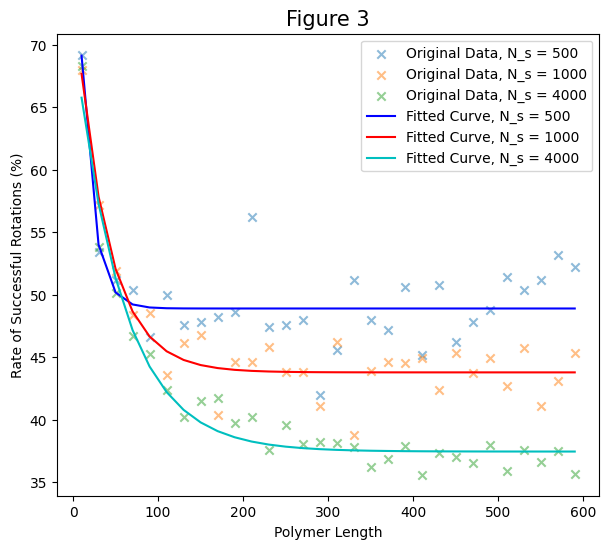

In [91]:
# Perform curve fitting
initialGuess = (1, 0.01, 1)

def func(x, a, b, c):
    """Mathematical function for regression."""
    return a * np.exp(-b * x) + c

popt1, pcov1 = curve_fit(func, arrN, successRate500, p0=initialGuess)
popt2, pcov2 = curve_fit(func, arrN, successRate1000, p0=initialGuess)
popt3, pcov3 = curve_fit(func, arrN, successRate4000, p0=initialGuess)

# Extract optimized parameters
aFit, bFit, cFit = popt1
d, e, f = popt2
g, h, i = popt3

# Generate y values using the fitted parameters
yPred500 = func(arrN, aFit, bFit, cFit)
yPred1000 = func(arrN, d, e, f)
yPred4000 = func(arrN, *popt3)

# Plot the original data and the fitted curve
plt.figure(figsize=(7,6))
plt.scatter(arrN, successRate500, marker="x", alpha=0.5, label='Original Data, N_s = 500')
plt.scatter(arrN, successRate1000, marker="x", alpha=0.5, label='Original Data, N_s = 1000')
plt.scatter(arrN, successRate4000, marker="x", alpha=0.5, label='Original Data, N_s = 4000')
plt.plot(arrN, yPred500, 'b-', label='Fitted Curve, N_s = 500')
plt.plot(arrN, yPred1000, 'r-', label='Fitted Curve, N_s = 1000')
plt.plot(arrN, yPred4000, 'c-', label='Fitted Curve, N_s = 4000')
plt.xlabel('Polymer Length')
plt.ylabel('Rate of Successful Rotations (%)')
plt.title('Figure 3', fontsize=15)
plt.legend()
plt.show()

Figure 3: The rate of succesful rotations as a function of the polymer length.

As the length $N$ of a polymer increases, the success rate of rotations decreases exponentially. Varying numbers of attempted rotations reveal different stabilization percentages with longer polymers showing lower stabilization values. This is likely due to their higher probability of attempting invalid rotations. A long polymer is more likely to fold over itself, because it has more opportunities for segments to intersect or overlap. Imagine a long line as having numerous segments or regions that can potentially cross over each other when rotated. In contrast, a short line has fewer segments or regions, reducing the chances of intersection or overlap when rotated.  **TODO: Skriv om diskusjonen til å bli riktig**

**(1j)** In order to enhance the realism of performed simulations, it is necessary to introduce a function to compute the energy of the polymer. It is well-established that systems strive to minimize their energy. Consequently, an algorithm known as the Metropolis algorithm will be implemented later on. This algorithm enables the polymer to prefer rotations that are not only valid but also energy-efficient. To facilitate this, an interaction energy matrix is utilized. This matrix assigns a value of -1 throughout, except along the three central diagonals, where it contains zeros in order to disregard the nearest-neighbor interactions that do not contribute to the total energy.

The matrix $b$ is used to enable all interactions that actually happen, namely those between monomers where the cityblock distance between them is 1.

The function `calculateEnergy` calculates the energy as discussed above, and is tested on the polymers from [1g](#task1g)

In [75]:
def calculateEnergy(polymer, V):
    """Input a polymer and an interaction energy-matrix, and return the total energy of the polymer."""

    # Create a boolean matrix, b, that returns true if two monomers are next to eachother
    b = cdist(polymer, polymer, 'cityblock') == 1

    # Create a new matrix by multiplying V and b elementwise
    #, that contains the interaction energy values from V where two monomers are next to eachother, i.e. where b is true
    energyMatrix = np.multiply(V,b)

    # Summate the individual energy-interactions, and return half of the sum
    return np.sum(energyMatrix)/2

# Create an interaction energy-matrix that is -1 everywhere but the three central diagonals, which contain zeros
V = np.zeros([len(polymer1000),len(polymer1000)])
V[np.tril_indices_from(V,-2)] = -1
V[np.triu_indices_from(V,2)] = -1

print(f'Energy for polymer of length 15 with 4 tried rotations: {calculateEnergy(polymer4,V)}')
print(f'Energy for polymer of length 15 with 1000 tried rotations: {calculateEnergy(polymer1000,V)}') 

Energy for polymer of length 15 with 4 tried rotations: -3.0
Energy for polymer of length 15 with 1000 tried rotations: -2.0


The polymers used to calculate these energies are the same that are depicted in figures 1 and 2. The only monomer pairs that contribute to the total energy of the polymer are those adjacent without being neighbors in the polymer chain. Observing the polymer in figure 1, we see that monomers 4, 5 and 6 interact with monomers 11, 10 and 9 respectively. In figure 2, the monomer pairs 0,3 and 10,13 are the only interaction. According to the interaction matrix $V$, these interaction all account for an energy of $-1$. It is therefore expected that the first polymer has an energy of $-3$ while the second has an energy of $-2$.

As discussed, the shapes of polymers in figures 1 and 2 will vary from execution to execution. As the princple of energy conservation and energy minimums are yet to be implemented, there will be no polymer that consequently achieves a lower energy than the other. 

**(2a)** The function `metropolis` is an implemented algorithm that runs a Monte Carlo simulation of a polymer in an interaction matrix $V$.  From this, a twisted polymer with corresponding energies is returned.

In [77]:
def metropolis(polymer, N_s, V, T):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns a twisted polymer and an array containing the energy of each twisted polymer."""

    beta = 1/(k_B*T)
    
    # Initialize required values for N, i and the energy, and an array for E
    N = len(polymer)
    energyArray = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    energyArray[0] = E
    i = 0

    while i < N_s:
        # Find the index of a random monomer, excluding the end-monomers, and use this as the coordinates to rotate about 
        xRand = np.random.randint(1, N-1)
        rotationOrigin = polymer[xRand]

        # Find a random direction, and use this and the rotation origin to create a twisted polymer
        clockwise = np.random.randint(0,2) == 1
        twistedPolymer = rotatePolymer(polymer, rotationOrigin, clockwise)

        # Check if the twisted polymer is intact, and if so calculate it's energy
        if isIntact(twistedPolymer, N):
            newE = calculateEnergy(twistedPolymer, V)

            # If the energy of this new polymer is lower than for the previous polymer, 
            # or a uniformly drawn random number is lower than a temperature-dependent probability, 
            # save this polymer as the new polymer, with correlating energy. Save this in the energy array, and increase the increment
            if newE < E or  np.random.uniform() < np.exp(-beta*(newE - E)):
                polymer = np.copy(twistedPolymer)
                E = newE
            energyArray[i] = E
            i += 1
            
    return polymer, energyArray

<a id='task2b' style='display:block; padding-top: 100px; margin-top: -100px;'></a>
**(2b)** Two simulations of the algorithm are run below with vastly differing temperatures to see the effect temperature has on the process.

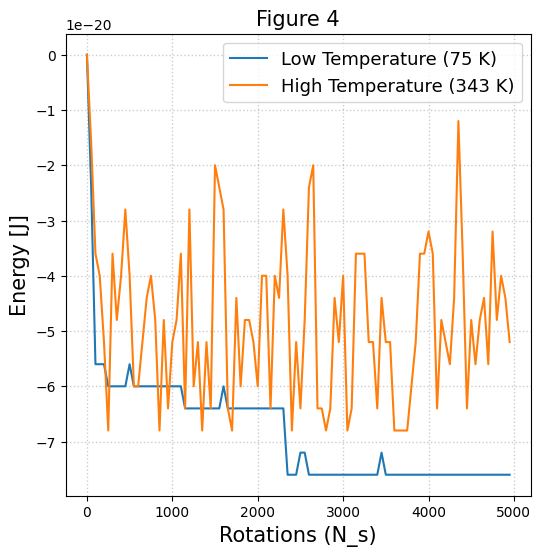

In [81]:
# Define N and correlating polymer for the remainder of the report
N = 30
polymer = createPolymer(N)

N_s = 5000
nonzeroE = -4e-21 #J

V = np.zeros([N, N])
V[np.tril_indices_from(V,-2)] = nonzeroE
V[np.triu_indices_from(V,2)] = nonzeroE

lowT = 75 #K
highT = 343 #K

lowTPolymer, lowTEnergyArray = metropolis(polymer, N_s, V, lowT)
highTPolymer, highTEnergyArray = metropolis(polymer, N_s, V, highT)

t = np.arange(0,len(lowTEnergyArray))

plt.figure(figsize=(6,6))
plt.title("Figure 4", fontsize=15)
plt.xlabel("Rotations (N_s)", fontsize=15)
plt.ylabel("Energy [J]", fontsize=15)
plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
plt.plot(t[::50],lowTEnergyArray[::50], label=f"Low Temperature ({lowT} K)")
plt.plot(t[::50],highTEnergyArray[::50], label=f"High Temperature ({highT} K)")
plt.legend(fontsize=13)
plt.show()

Figure 4: Visualization of a polymer's energy during rotation at high and low temperatures.

The simulation of the polymer at the lower temperature results in the most stable, and often lowest energy observed throughout the simulation. This is attributable to the heightened probability of energy-efficient rotations for a polymer in a lower temperature environment. Despite the system's inclination to minimize energy, thermal fluctuations can still induce energy-inefficient rotations. As temperature increases, the likelihood of such fluctuations rises. 

As a result, the polymer at lower temperatures quickly settles into a local energy minimum after a few rotations. In this state, there are fewer opportunities for energy-efficient rotations. Combined with the low likelihood of energy-inefficient rotations in a low-temperature environment, this results in fewer overall rotations for the polymer.

**(2c)** By visualizing and examining the polymers in their final states, it can be observed that the polymer subjected to lower temperature conditions undergoes more energy-efficient rotations resulting in a more folded shape. Conversely, the polymer exposed to higher temperatures tends to adopt a more extended configuration.

<a id='task2c' style='display:block; padding-top: 100px; margin-top: -100px;'></a>

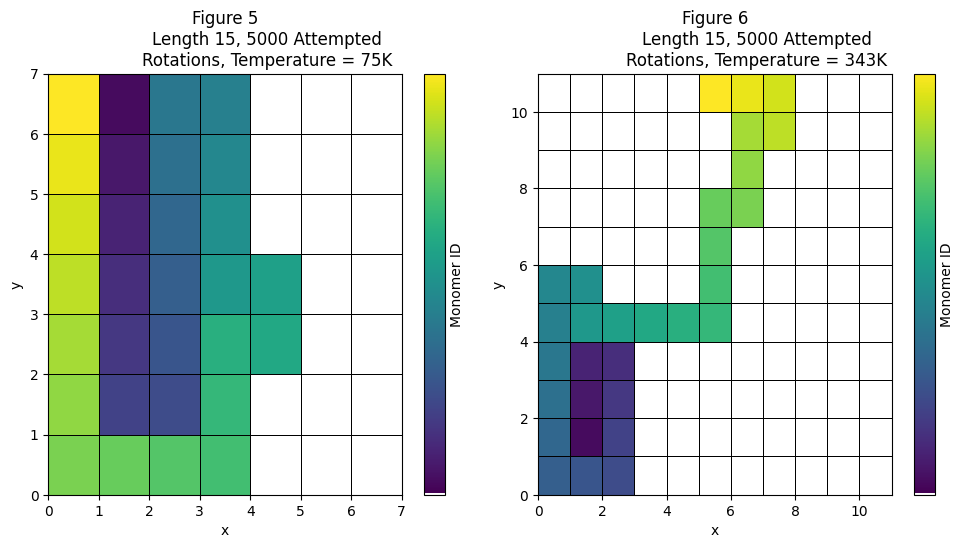

In [82]:
polymerData = np.array([lowTPolymer, highTPolymer])
fig, axs = plt.subplots(1, len(polymerData), figsize=(10, 5))

for i, polymer in enumerate(polymerData):
    visualizeMultiplePolymers(polymer, axs[i])

plt.tight_layout()
axs[0].set_title("""Figure 5
                Length 15, 5000 Attempted
                Rotations, Temperature = 75K""")
axs[1].set_title("""Figure 6
                Length 15, 5000 Attempted
                Rotations, Temperature = 343K""")
plt.show()

Figure 5, 6: The figures above illustrate that the polymer at lower temperatures exhibits more folding compared to the polymer at higher temperatures. 

This observation aligns with the tendency for polymers at higher temperatures to undergo energy-inefficient rotations. A polymer undergoing solely energy-efficient rotations will gradually adopt a folded structure, consistent with the curled appearance observed in Figure 5.

**(2d)** To further test how the interaction matrix affects a polymer, a new specific matrix will be made. For the $V$ matrix, all elements are set to zero except for the lower left and upper right corners, which have been set to $-100 \times 10^{-20} \text{J}$. The purpose of this energy distribution is to facilitate interaction of the polymer endpoints. This interaction between the two endpoints represents the only energy-efficient folding of the polymer in this configuration, leading to their eventual connection.

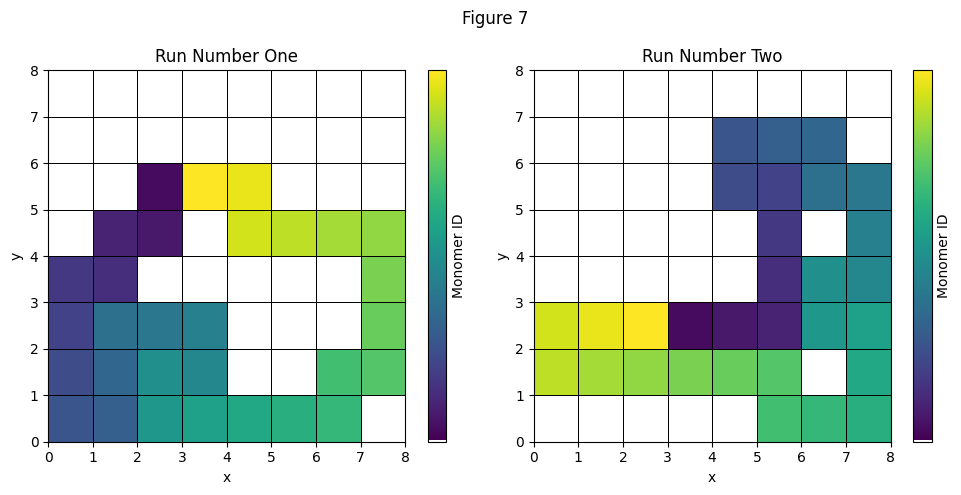

In [19]:
extraPolymer = np.copy(polymer)
unevenV = np.zeros([N, N])
unevenV[0][-1] = -100e-20
unevenV[-1][0] = -100e-20

for i in range(1, len(polymer//2 + 1)):
    unevenV[i:-i, i:-i] *=10

unevenPolymer1, unevenE1 = metropolis(polymer, 10000, unevenV, 150)
unevenPolymer2, unevenE2 = metropolis(extraPolymer, 10000, unevenV, 150)

polymerArray = np.array([unevenPolymer1, unevenPolymer2])

# Visualize the end position of the two tests
fig, axs = plt.subplots(1, len(polymerArray), figsize=(10, 5))
plt.suptitle("Figure 7")

# Plot each run on a separate subplot
for i, polymer in enumerate(polymerArray):
    visualizeMultiplePolymers(polymer, axs[i])

axs[0].set_title('Run Number One')
axs[1].set_title('Run Number Two')
plt.tight_layout()
plt.show()

Figure 7: The two polymers have connected endpoints.

As expected, the ends of the polymers have connected. This simple example shows that the configuration of $V$ can lead to polymers folding into predictable shapes. It could be experimented further with more complicated examples, but this is outside the scope of this discussion. 

**(2e)** To gain deeper insights into how the energy varies with the rotation of the polymer across different temperatures, the mean energy and the standard deviation of the energy as temperature varies can be computed and analyzed.

<a id='task2e' style='display:block; padding-top: 100px; margin-top: -100px;'></a>

In [83]:
#Define an array of temperatures to be used for the remainder of this report
Temperature = np.arange(10,1000,30)

def energyPerT(N_s):
    """Inputs number of attempted rotations, and returns an array containing the energy per temperature."""
    
    energyArray = np.zeros([33, N_s - 1000])

    for i in range(len(Temperature)):
        energyArray[i] = metropolis(polymer, N_s, V, Temperature[i])[1][1000:]

    return energyArray

In [84]:
runNs1500 = energyPerT(1500)
runNs3000 = energyPerT(3000)
runNs6000 = energyPerT(6000)

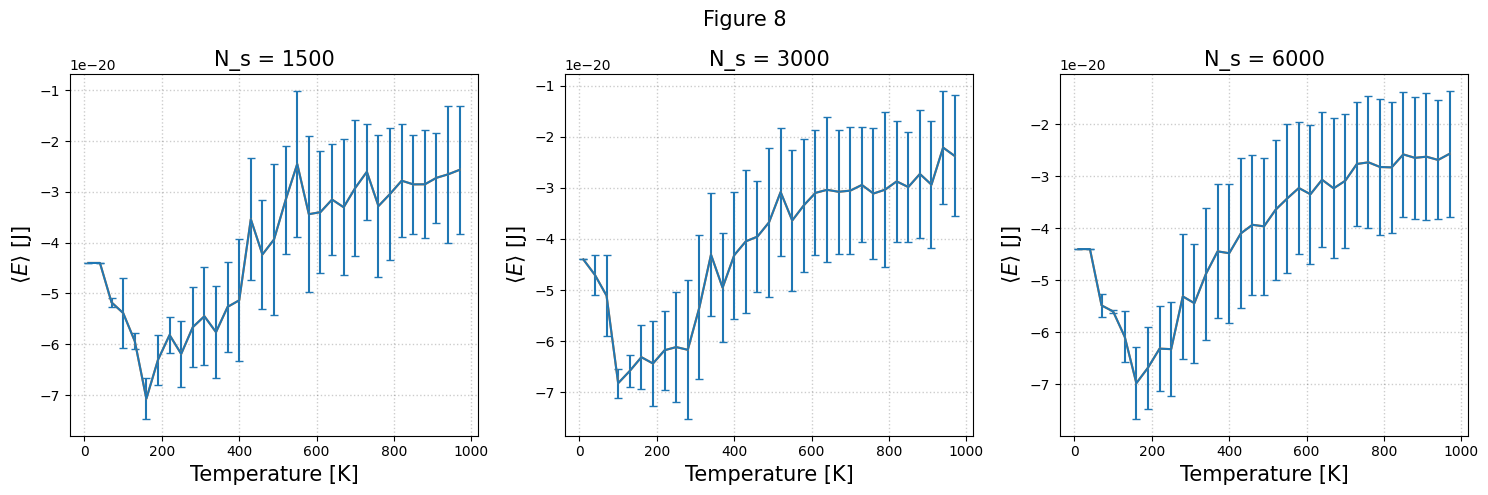

In [23]:
meanRunNs1500 = np.mean(runNs1500, axis=1)
stdRunNs1500 = np.std(runNs1500, ddof=1, axis=1)

meanRunNs3000 = np.mean(runNs3000, axis=1)
stdRunNs3000 = np.std(runNs3000, ddof=1, axis=1)

meanRunNs6000 = np.mean(runNs6000, axis=1)
stdRunNs6000 = np.std(runNs6000, ddof=1, axis=1)

# Create figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
plt.suptitle("Figure 8", fontsize=15)

# Plot data on the first subplot
axs[0].errorbar(Temperature, meanRunNs1500, yerr=stdRunNs1500, fmt='-', capsize=3)
axs[0].plot(Temperature, meanRunNs1500)
axs[0].grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
axs[0].set_xlabel("Temperature [K]", fontsize=15)
axs[0].set_ylabel("$\\langle E \\rangle$ [J]", fontsize=15)
axs[0].set_title('N_s = 1500', fontsize=15)

# Plot data on the second subplot
axs[1].errorbar(Temperature, meanRunNs3000, yerr=stdRunNs3000, fmt='-', capsize=3)
axs[1].plot(Temperature, meanRunNs3000)
axs[1].grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
axs[1].set_xlabel("Temperature [K]", fontsize=15)
axs[1].set_ylabel("$\\langle E \\rangle$ [J]", fontsize=15)
axs[1].set_title("N_s = 3000", fontsize=15)

# Plot data on the third subplot
axs[2].errorbar(Temperature, meanRunNs6000, yerr=stdRunNs6000, fmt='-', capsize=3)
axs[2].plot(Temperature, meanRunNs6000)
axs[2].grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
axs[2].set_xlabel("Temperature [K]", fontsize=15)
axs[2].set_ylabel("$\\langle E \\rangle$ [J]", fontsize=15)
axs[2].set_title('N_s = 6000', fontsize=15)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Figure 8: The mean energy as a function of temperature, with errorbars representing the standard deviation.

Observing the plot, it becomes evident that the magnitude of the mean energy decreases as temperatures rise. This observation aligns with the findings presented in [2b](#task2b). Additionally, an increase in temperature corresponds to an escalation in the magnitude of the standard deviation. This correspondence is consistent with earlier observations, where the polymer's energy exhibits considerable sporadic fluctuations at higher temperatures. Consequently, the standard deviation appears significantly larger in comparison to the mean energy, as depicted in the plot.

Qualitatively, the shapes of the three curves look very similar. It appears that $N_s$ does not alter the temperature dependency of the energy.

**(2f)** Conducting 10 additional simulations using one of the lowest temperatures employed in [2e](#task2e) enables a more thorough examination of the polymer's energy landscape at a lower temperature. Plotting $E(t)$, where $t$ is the number of valid rotations attempted by `metropolis`, from each simulation in a unified graph allows us to discern the variations in energy levels among multiple simulations.

This analysis yields valuable insights into the stability and fluctuations of the polymer's energy at lower temperatures. A narrower distribution of energy values signifies a more stable energy state for the polymer, while a broader distribution indicates higher fluctuations in energy levels.

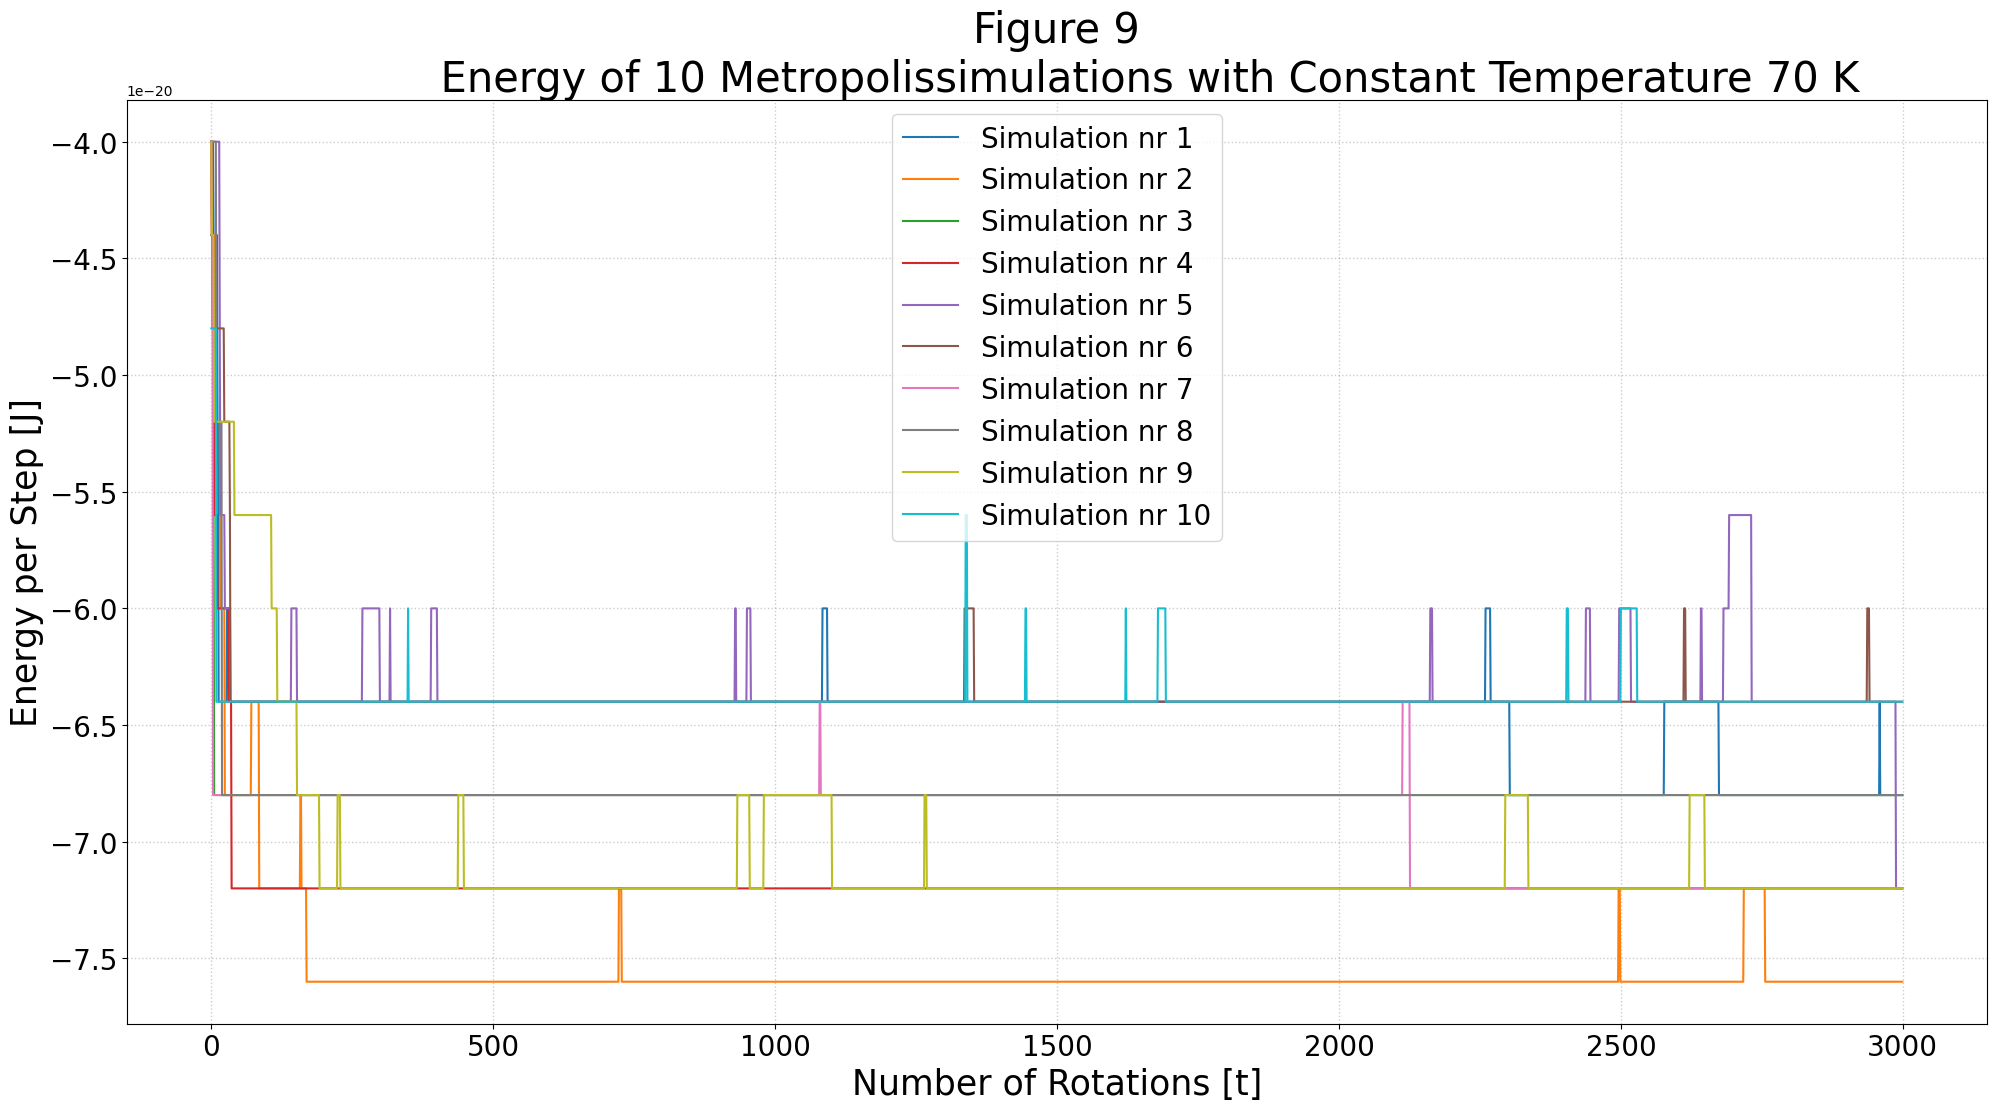

In [86]:
T = 70 #K
N_s = 3000

def energyConstantT(T, N_s, V):
    """Inputs a temperature, number of attempted rotations and an interaction-energy matrix, 
    and plots ten simulations for the energy as a function of number of rotations."""

    iArr = np.arange(0, N_s)

    plt.figure(figsize=(24, 12))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Number of Rotations [t]", fontsize=25)
    plt.ylabel("Energy per Step [J]", fontsize=25)
    plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
    plt.title(f"""Figure 9
              Energy of 10 Metropolissimulations with Constant Temperature {T} K""", fontsize=30)
    
    for i in range(1, 11):
        metro = metropolis(polymer, N_s, V, T)
        plt.plot(iArr, metro[1], label = f"Simulation nr {i}")
    
    plt.legend(fontsize=20)

energyConstantT(T, N_s, V)

Figure 9: Visualizing 10 metropolissimulations, all at the same temperature.

The plot illustrates that polymers at lower temperatures swiftly converge to a rotation that positions them within a local energy minimum. Notably, the majority of polymers reach their initial local minima within the first $0-100$ rotations. Subsequently, once situated within an energy minimum, the polymer's available energy-efficient rotation possibilities become limited. Consequently, the polymer refrains from executing rotations until an energy-efficient option is identified. However, occasional deviations from this behavior occur, characterized by energy-inefficient rotations, primarily attributed to thermal fluctuations as discussed in [2b](#task2b).

**TODO: Hvordan og hvorfor kan dette brukes til å bedre anslå energien til en polymer med lavere temperatur?**

**(2g)** Another intriguing aspect of polymer rotation is how the maximum distance between two monomers evolve as rotations occur. The `metropolis` algorithm is therefore extended to provide $d(T)$, which represents the maximum distance between two monomers in the polymer for every rotation done. `cdist` is utilized to calculate this distance. The function of `cdist` is to compute the pairwise distances between the $N$ monomers in a polymer, with the `"euclid"` parameter indicating the use of the Euclidean distance metric.

In [26]:
# 2g

def getEuclideanDistance(polymer):
    """Inputs a polymer and returns the largest distance between any two monomers."""
    return np.max(cdist(polymer, polymer, 'euclid'))

def metropolisWithD(polymer, N_s, V, T):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns a twisted polymer, an array containing the energy of each twisted polymer, and an array containing the biggest distance between two monomers for each twisted polymer."""

    beta = 1/(k_B*T)

    N = len(polymer)
    energyArray = np.zeros(N_s)
    dArr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    energyArray[0] = E
    i = 0
    
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        rotationOrigin = polymer[xRand]

        clockwise = bool(np.random.randint(0,2))
        twistedPolymer = rotatePolymer(polymer,rotationOrigin, clockwise)

        if isIntact(twistedPolymer, N):
            newE = calculateEnergy(twistedPolymer, V)
            
            if newE < E or np.random.uniform() < np.exp(-beta*(newE - E)):
                polymer = np.copy(twistedPolymer)
                E = newE
            energyArray[i] = E
            dArr[i] = getEuclideanDistance(polymer)
            i += 1

    return polymer, energyArray, dArr

For this simulation we need a $V$ matrix, where all the elements are randomly selected from a given interval, excluding the null-elements.

In [89]:
# Define the interval
lowerBound = -6e-21
upperBound = -2e-21

# Generate a random upper triangular matrix within the specified interval
randomMatrix = (upperBound - lowerBound) * np.random.rand(N, N) + lowerBound
upperTriangular = np.triu(randomMatrix, 1)

# Construct the symmetrical matrix by copying the upper triangular part to the lower triangular part
symmetricalMatrix = upperTriangular + upperTriangular.T

# Set the diagonal elements and the diagonals on each side of the main diagonal to zero
for i in range(N):
    symmetricalMatrix[i, i] = 0
    if i > 0:
        symmetricalMatrix[i, i-1] = 0
        symmetricalMatrix[i-1, i] = 0


Plotting the mean diameter as a funtion of the temperature changes.

In [90]:
%%time 
#to get the runtime of the cell

dArray = np.zeros([33, 9000])
eArray = np.zeros([33, 9000])

for i in range(len(Temperature)):
    dArray[i] = metropolisWithD(polymer, 10000, symmetricalMatrix, Temperature[i])[2][1000:]
    eArray[i] = metropolisWithD(polymer, 10000, symmetricalMatrix, Temperature[i])[1][1000:]


meansDArray = np.array([np.mean(subarray) for subarray in dArray])
meansEArray = np.array([np.mean(subarray) for subarray in eArray])

CPU times: total: 47.4 s
Wall time: 1min 52s


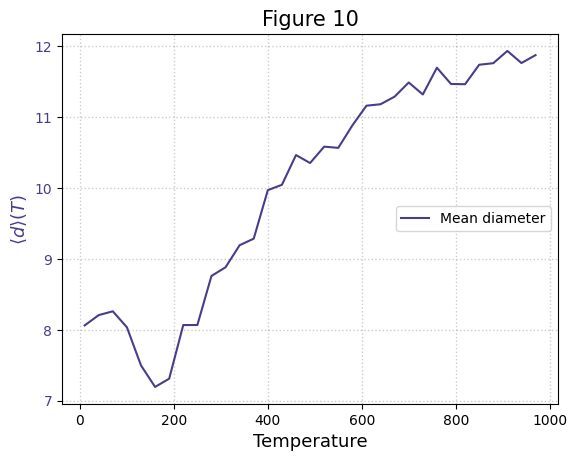

In [35]:
plt.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
plt.ylabel('$\\langle d \\rangle (T)$', fontsize=13, color='darkslateblue')
plt.xlabel('Temperature', fontsize=13)
plt.tick_params(axis='y', labelcolor='darkslateblue')
plt.legend(loc='center right')
plt.title('Figure 10', fontsize=15)

plt.show()

Figure 10: The mean diameter visualized as a function of the temperature.

The reduction in mean diameter with an increased number of interactions between polymers is attributed to the formation of a folded shape configuration resulting from extensive monomer interactions, as visually depicted in [Figure 5](#task2c).

At lower temperatures, the predominant occurrence of energy-efficient rotations leads to a higher density of interactions between monomers, consequently resulting in a smaller mean diameter. Conversely, elevated temperatures induce energy-inefficient rotations, diminishing the frequency of monomer interactions and consequently yielding a larger mean diameter.

This phenomenon is accurately illustrated in the visualization, which portrays the relationship described.

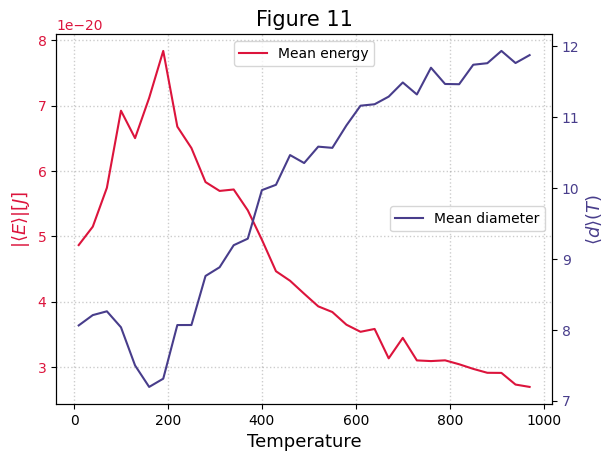

In [36]:
# Create figure and axes
fig, ax1 = plt.subplots()

# Plot on the first axes
ax1.plot(Temperature, np.abs(meansEArray), '-', label='Mean energy', color="crimson")
ax1.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
ax1.set_xlabel('Temperature', fontsize=13)
ax1.set_ylabel('$|\\langle E \\rangle| [J]$', color='crimson', fontsize=13)
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.legend(loc='upper center')
ax1.set_title('Figure 11', fontsize=15)

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
ax2.set_ylabel('$\\langle d \\rangle (T)$', color='darkslateblue', fontsize=13)
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.legend(loc='center right')

plt.show()

Figure 11: A shared plot depicting the mean energy and mean diameter as functions of temperature.

In this visualization, the magnitude of both mean energy and mean diameter is presented on a shared plot, utilizing distinct scales on the y-axes to accurately represent both variables. This method enables a thorough comparison of the trends exhibited by mean energy and mean diameter, despite their potentially differing numerical ranges.

An observation from the visualization is that as the mean diameter decreases, there is a corresponding increase in mean energy. This observation is consistent with the understanding that an increase in interactions between monomers results in a larger magnitude of mean energy.

**(2h)** Opposed to the previous simulation, the polymer will be rotated while going from the highest temperature to the lowest. Starting at the highest temperature and gradually decreasing it without resetting the polymer to a horizontal position between temperature changes will simulate the fundamental physical process of cooling.



In [37]:
def metropolisWithDReverseT(V, N_s, T, polymer):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns an array containing the average maximum distance between two monomers."""

    Temperature = np.arange(T, 10, -30)
    dArr = np.zeros(len(Temperature))
    
    for i in range(len(Temperature)):
        polymer, E, d = metropolisWithD(polymer, N_s, V, Temperature[i])
        dArr[i] = np.mean(d)
    return dArr, Temperature

dArr, T = metropolisWithDReverseT(V, N_s, 1000, polymer)

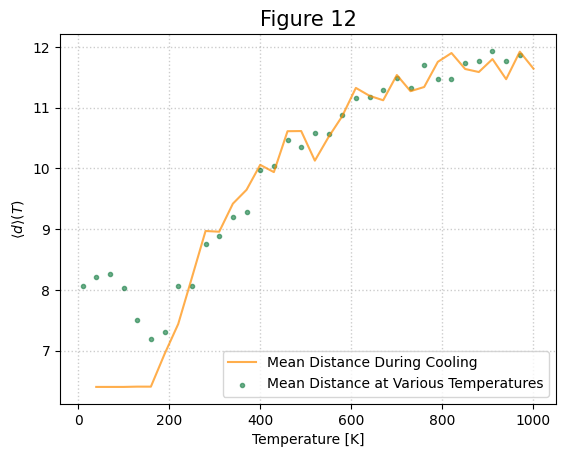

In [53]:
plt.plot(T, dArr, alpha=0.7, color="darkorange", label="Mean Distance During Cooling")
plt.scatter(Temperature, meansDArray, alpha=0.7, marker=".", color="seagreen", label="Mean Distance at Various Temperatures")
plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
plt.xlabel('Temperature [K]')
plt.ylabel('$\\langle d \\rangle (T)$')
plt.title("Figure 12", fontsize=15)
plt.legend()
plt.show()

Figure 12: The mean distance of a polymer undergoing a cooling process compared to the mean distance after a Metropolis simulation for various temperatures.

**TODO: Drøft**

### Conclusion

In this project, a straightforward polymer was subjected to various physical principles to manipulate its shape, simulating real-world scenarios. The utilization of Monte Carlo simulations facilitated this exploration. The findings reveal that when a polymer undergoes energy-efficient rotations, it inevitably adopts a curled configuration driven by fundamental physical factors. This insight sheds light on the intricate dynamics governing polymer behavior, highlighting the intricate interplay between energy dynamics and structural formation.